In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(716456, 828)
(716456, 1)
validation
(107504, 828)
(107504, 1)
test
(80848, 828)
(80848, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/72 [..............................] - ETA: 1:30 - loss: 0.0390 - STD: 1.8823e-04 - MAE: 0.1799

 4/72 [>.............................] - ETA: 1s - loss: 0.0231 - STD: 2.2732e-04 - MAE: 0.1207  

 5/72 [=>............................] - ETA: 2s - loss: 0.0233 - STD: 2.1305e-04 - MAE: 0.1213

 6/72 [=>............................] - ETA: 2s - loss: 0.0234 - STD: 2.0055e-04 - MAE: 0.1212

 7/72 [=>............................] - ETA: 3s - loss: 0.0230 - STD: 1.9053e-04 - MAE: 0.1195

 8/72 [==>...........................] - ETA: 3s - loss: 0.0222 - STD: 1.8293e-04 - MAE: 0.1166

 9/72 [==>...........................] - ETA: 3s - loss: 0.0212 - STD: 1.7769e-04 - MAE: 0.1131

10/72 [===>..........................] - ETA: 3s - loss: 0.0201 - STD: 1.7462e-04 - MAE: 0.1092

11/72 [===>..........................] - ETA: 3s - loss: 0.0192 - STD: 1.7319e-04 - MAE: 0.1065

12/72 [====>.........................] - ETA: 3s - loss: 0.0185 - STD: 1.7320e-04 - MAE: 0.1050

13/72 [====>.........................] - ETA: 3s - loss: 0.0181 - STD: 1.7410e-04 - MAE: 0.1045

14/72 [====>.........................] - ETA: 3s - loss: 0.0178 - STD: 1.7554e-04 - MAE: 0.1044

15/72 [=====>........................] - ETA: 3s - loss: 0.0175 - STD: 1.7755e-04 - MAE: 0.1040

16/72 [=====>........................] - ETA: 3s - loss: 0.0172 - STD: 1.8003e-04 - MAE: 0.1032

17/72 [======>.......................] - ETA: 3s - loss: 0.0168 - STD: 1.8215e-04 - MAE: 0.1020

18/72 [======>.......................] - ETA: 3s - loss: 0.0164 - STD: 1.8423e-04 - MAE: 0.1006

19/72 [======>.......................] - ETA: 3s - loss: 0.0160 - STD: 1.8598e-04 - MAE: 0.0993

20/72 [=======>......................] - ETA: 3s - loss: 0.0157 - STD: 1.8751e-04 - MAE: 0.0981

21/72 [=======>......................] - ETA: 3s - loss: 0.0155 - STD: 1.8908e-04 - MAE: 0.0971

22/72 [========>.....................] - ETA: 3s - loss: 0.0153 - STD: 1.9062e-04 - MAE: 0.0962

23/72 [========>.....................] - ETA: 3s - loss: 0.0151 - STD: 1.9234e-04 - MAE: 0.0953

24/72 [=========>....................] - ETA: 2s - loss: 0.0150 - STD: 1.9433e-04 - MAE: 0.0946

25/72 [=========>....................] - ETA: 2s - loss: 0.0148 - STD: 1.9672e-04 - MAE: 0.0938

26/72 [=========>....................] - ETA: 2s - loss: 0.0146 - STD: 1.9965e-04 - MAE: 0.0931

27/72 [==========>...................] - ETA: 2s - loss: 0.0144 - STD: 2.0293e-04 - MAE: 0.0925

28/72 [==========>...................] - ETA: 2s - loss: 0.0143 - STD: 2.0660e-04 - MAE: 0.0920

29/72 [===========>..................] - ETA: 2s - loss: 0.0141 - STD: 2.1070e-04 - MAE: 0.0915

30/72 [===========>..................] - ETA: 3s - loss: 0.0140 - STD: 2.1513e-04 - MAE: 0.0912

34/72 [=============>................] - ETA: 2s - loss: 0.0135 - STD: 2.3291e-04 - MAE: 0.0902

35/72 [=============>................] - ETA: 2s - loss: 0.0134 - STD: 2.3713e-04 - MAE: 0.0898

36/72 [==============>...............] - ETA: 2s - loss: 0.0133 - STD: 2.4129e-04 - MAE: 0.0895

37/72 [==============>...............] - ETA: 2s - loss: 0.0132 - STD: 2.4537e-04 - MAE: 0.0892

38/72 [==============>...............] - ETA: 2s - loss: 0.0131 - STD: 2.4928e-04 - MAE: 0.0888

39/72 [===============>..............] - ETA: 2s - loss: 0.0130 - STD: 2.5321e-04 - MAE: 0.0884

40/72 [===============>..............] - ETA: 2s - loss: 0.0129 - STD: 2.5726e-04 - MAE: 0.0881

41/72 [================>.............] - ETA: 2s - loss: 0.0129 - STD: 2.6147e-04 - MAE: 0.0878

42/72 [================>.............] - ETA: 2s - loss: 0.0128 - STD: 2.6592e-04 - MAE: 0.0875

43/72 [================>.............] - ETA: 2s - loss: 0.0127 - STD: 2.7041e-04 - MAE: 0.0872

44/72 [=================>............] - ETA: 2s - loss: 0.0126 - STD: 2.7526e-04 - MAE: 0.0869

45/72 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 2.8040e-04 - MAE: 0.0867

46/72 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 2.8583e-04 - MAE: 0.0865

47/72 [==================>...........] - ETA: 1s - loss: 0.0124 - STD: 2.9155e-04 - MAE: 0.0863

48/72 [===================>..........] - ETA: 1s - loss: 0.0124 - STD: 2.9752e-04 - MAE: 0.0862

49/72 [===================>..........] - ETA: 1s - loss: 0.0123 - STD: 3.0353e-04 - MAE: 0.0861

50/72 [===================>..........] - ETA: 1s - loss: 0.0123 - STD: 3.0971e-04 - MAE: 0.0859

51/72 [====================>.........] - ETA: 1s - loss: 0.0122 - STD: 3.1600e-04 - MAE: 0.0858

52/72 [====================>.........] - ETA: 1s - loss: 0.0122 - STD: 3.2223e-04 - MAE: 0.0856

53/72 [=====================>........] - ETA: 1s - loss: 0.0121 - STD: 3.2867e-04 - MAE: 0.0854

54/72 [=====================>........] - ETA: 1s - loss: 0.0121 - STD: 3.3507e-04 - MAE: 0.0853

55/72 [=====================>........] - ETA: 1s - loss: 0.0120 - STD: 3.4159e-04 - MAE: 0.0851

56/72 [======================>.......] - ETA: 1s - loss: 0.0120 - STD: 3.4823e-04 - MAE: 0.0849

57/72 [======================>.......] - ETA: 1s - loss: 0.0120 - STD: 3.5492e-04 - MAE: 0.0848

58/72 [=======================>......] - ETA: 1s - loss: 0.0119 - STD: 3.6200e-04 - MAE: 0.0846

59/72 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 3.6917e-04 - MAE: 0.0845

60/72 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 3.7693e-04 - MAE: 0.0843

61/72 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 3.8506e-04 - MAE: 0.0842

62/72 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 3.9353e-04 - MAE: 0.0841

63/72 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 4.0222e-04 - MAE: 0.0840

64/72 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 4.1119e-04 - MAE: 0.0839

65/72 [==========================>...] - ETA: 0s - loss: 0.0117 - STD: 4.2039e-04 - MAE: 0.0838

66/72 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 4.2993e-04 - MAE: 0.0837

67/72 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 4.3991e-04 - MAE: 0.0836

68/72 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 4.5003e-04 - MAE: 0.0835

69/72 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 4.6049e-04 - MAE: 0.0834

70/72 [============================>.] - ETA: 0s - loss: 0.0115 - STD: 4.7113e-04 - MAE: 0.0833

71/72 [============================>.] - ETA: 0s - loss: 0.0115 - STD: 4.8208e-04 - MAE: 0.0832

72/72 [==============================] - ETA: 0s - loss: 0.0114 - STD: 4.9360e-04 - MAE: 0.0831

72/72 [==============================] - 7s 81ms/step - loss: 0.0114 - STD: 4.9360e-04 - MAE: 0.0831 - val_loss: 0.0102 - val_STD: 0.0011 - val_MAE: 0.0792


Epoch 2/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0096 - STD: 0.0014 - MAE: 0.0767

 2/72 [..............................] - ETA: 5s - loss: 0.0097 - STD: 0.0014 - MAE: 0.0769

 3/72 [>.............................] - ETA: 4s - loss: 0.0096 - STD: 0.0014 - MAE: 0.0769

 4/72 [>.............................] - ETA: 4s - loss: 0.0096 - STD: 0.0015 - MAE: 0.0769

 5/72 [=>............................] - ETA: 4s - loss: 0.0096 - STD: 0.0015 - MAE: 0.0769

 6/72 [=>............................] - ETA: 4s - loss: 0.0095 - STD: 0.0015 - MAE: 0.0767

 7/72 [=>............................] - ETA: 4s - loss: 0.0095 - STD: 0.0016 - MAE: 0.0767

 8/72 [==>...........................] - ETA: 4s - loss: 0.0095 - STD: 0.0016 - MAE: 0.0768

 9/72 [==>...........................] - ETA: 4s - loss: 0.0095 - STD: 0.0016 - MAE: 0.0769

10/72 [===>..........................] - ETA: 4s - loss: 0.0095 - STD: 0.0017 - MAE: 0.0768

11/72 [===>..........................] - ETA: 4s - loss: 0.0095 - STD: 0.0017 - MAE: 0.0769

12/72 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.0018 - MAE: 0.0768

13/72 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.0018 - MAE: 0.0767

14/72 [====>.........................] - ETA: 3s - loss: 0.0094 - STD: 0.0018 - MAE: 0.0766

15/72 [=====>........................] - ETA: 3s - loss: 0.0094 - STD: 0.0019 - MAE: 0.0765

16/72 [=====>........................] - ETA: 3s - loss: 0.0094 - STD: 0.0019 - MAE: 0.0765

17/72 [======>.......................] - ETA: 3s - loss: 0.0094 - STD: 0.0020 - MAE: 0.0765

18/72 [======>.......................] - ETA: 3s - loss: 0.0094 - STD: 0.0021 - MAE: 0.0764

19/72 [======>.......................] - ETA: 3s - loss: 0.0094 - STD: 0.0021 - MAE: 0.0764

20/72 [=======>......................] - ETA: 3s - loss: 0.0094 - STD: 0.0022 - MAE: 0.0764

21/72 [=======>......................] - ETA: 3s - loss: 0.0094 - STD: 0.0022 - MAE: 0.0764

22/72 [========>.....................] - ETA: 3s - loss: 0.0094 - STD: 0.0023 - MAE: 0.0764

23/72 [========>.....................] - ETA: 3s - loss: 0.0094 - STD: 0.0024 - MAE: 0.0764

24/72 [=========>....................] - ETA: 3s - loss: 0.0094 - STD: 0.0025 - MAE: 0.0764

25/72 [=========>....................] - ETA: 3s - loss: 0.0094 - STD: 0.0025 - MAE: 0.0764

26/72 [=========>....................] - ETA: 3s - loss: 0.0094 - STD: 0.0026 - MAE: 0.0764

27/72 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0027 - MAE: 0.0764

28/72 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0028 - MAE: 0.0763

29/72 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0029 - MAE: 0.0764

30/72 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0030 - MAE: 0.0763

31/72 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0031 - MAE: 0.0763

32/72 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0032 - MAE: 0.0763

33/72 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0033 - MAE: 0.0763

34/72 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0035 - MAE: 0.0762

35/72 [=============>................] - ETA: 2s - loss: 0.0093 - STD: 0.0036 - MAE: 0.0762

36/72 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0037 - MAE: 0.0762

37/72 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0039 - MAE: 0.0761

38/72 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0040 - MAE: 0.0761

39/72 [===============>..............] - ETA: 2s - loss: 0.0093 - STD: 0.0042 - MAE: 0.0760

41/72 [================>.............] - ETA: 2s - loss: 0.0093 - STD: 0.0046 - MAE: 0.0759

42/72 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0048 - MAE: 0.0758

43/72 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 0.0050 - MAE: 0.0758

44/72 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0052 - MAE: 0.0757

45/72 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0054 - MAE: 0.0757

46/72 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0057 - MAE: 0.0756

47/72 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0060 - MAE: 0.0755

48/72 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0062 - MAE: 0.0755

49/72 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0065 - MAE: 0.0754

50/72 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0068 - MAE: 0.0753

51/72 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0071 - MAE: 0.0752

52/72 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0075 - MAE: 0.0752

53/72 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0078 - MAE: 0.0751

54/72 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.0082 - MAE: 0.0750

55/72 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.0086 - MAE: 0.0749

56/72 [======================>.......] - ETA: 1s - loss: 0.0090 - STD: 0.0090 - MAE: 0.0749

57/72 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.0094 - MAE: 0.0748

58/72 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0098 - MAE: 0.0747

59/72 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0102 - MAE: 0.0746

60/72 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.0106 - MAE: 0.0745

61/72 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.0111 - MAE: 0.0744

62/72 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.0115 - MAE: 0.0743

63/72 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0120 - MAE: 0.0743

64/72 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0124 - MAE: 0.0742

65/72 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0128 - MAE: 0.0741

66/72 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0133 - MAE: 0.0740

67/72 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0137 - MAE: 0.0739

68/72 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0141 - MAE: 0.0738

69/72 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0145 - MAE: 0.0737

70/72 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0149 - MAE: 0.0736

71/72 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0153 - MAE: 0.0736

72/72 [==============================] - ETA: 0s - loss: 0.0087 - STD: 0.0157 - MAE: 0.0735

72/72 [==============================] - 5s 69ms/step - loss: 0.0087 - STD: 0.0157 - MAE: 0.0735 - val_loss: 0.0077 - val_STD: 0.0336 - val_MAE: 0.0685


Epoch 3/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0658

 2/72 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0663

 3/72 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0666

 4/72 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0667

 5/72 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0666

 6/72 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0665

 7/72 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0665

 8/72 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.0415 - MAE: 0.0664

 9/72 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.0416 - MAE: 0.0662

10/72 [===>..........................] - ETA: 4s - loss: 0.0072 - STD: 0.0417 - MAE: 0.0661

11/72 [===>..........................] - ETA: 4s - loss: 0.0072 - STD: 0.0418 - MAE: 0.0660

12/72 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0420 - MAE: 0.0659

13/72 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0422 - MAE: 0.0659

14/72 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0425 - MAE: 0.0658

15/72 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0427 - MAE: 0.0657

16/72 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0655

17/72 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0432 - MAE: 0.0654

18/72 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0435 - MAE: 0.0654

19/72 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0438 - MAE: 0.0653

21/72 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0443 - MAE: 0.0651

22/72 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0446 - MAE: 0.0650

23/72 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0449 - MAE: 0.0649

24/72 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.0451 - MAE: 0.0649

25/72 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.0454 - MAE: 0.0647

26/72 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0456 - MAE: 0.0646

27/72 [==========>...................] - ETA: 2s - loss: 0.0069 - STD: 0.0458 - MAE: 0.0645

28/72 [==========>...................] - ETA: 2s - loss: 0.0069 - STD: 0.0461 - MAE: 0.0644

29/72 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0463 - MAE: 0.0644

30/72 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0465 - MAE: 0.0643

31/72 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0468 - MAE: 0.0643

32/72 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0469 - MAE: 0.0642

33/72 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0471 - MAE: 0.0641

34/72 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.0473 - MAE: 0.0640

35/72 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.0475 - MAE: 0.0639

36/72 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0476 - MAE: 0.0638

37/72 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0478 - MAE: 0.0638

38/72 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0480 - MAE: 0.0637

39/72 [===============>..............] - ETA: 2s - loss: 0.0068 - STD: 0.0482 - MAE: 0.0636

40/72 [===============>..............] - ETA: 2s - loss: 0.0068 - STD: 0.0483 - MAE: 0.0635

41/72 [================>.............] - ETA: 2s - loss: 0.0067 - STD: 0.0485 - MAE: 0.0635

42/72 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0486 - MAE: 0.0634

43/72 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0487 - MAE: 0.0633

44/72 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0489 - MAE: 0.0632

45/72 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0491 - MAE: 0.0631

46/72 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0492 - MAE: 0.0630

47/72 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0493 - MAE: 0.0629

48/72 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0496 - MAE: 0.0629

49/72 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0497 - MAE: 0.0628

50/72 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0498 - MAE: 0.0627

51/72 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0500 - MAE: 0.0627

52/72 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0501 - MAE: 0.0626

53/72 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0625

54/72 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0624

55/72 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0506 - MAE: 0.0624

56/72 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0507 - MAE: 0.0623

57/72 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0508 - MAE: 0.0623

58/72 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0510 - MAE: 0.0622

59/72 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0511 - MAE: 0.0622

60/72 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0512 - MAE: 0.0621

61/72 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0621

62/72 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0515 - MAE: 0.0620

63/72 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0516 - MAE: 0.0620

64/72 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0517 - MAE: 0.0619

65/72 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0618

66/72 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0520 - MAE: 0.0618

67/72 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0521 - MAE: 0.0617

68/72 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0522 - MAE: 0.0617

69/72 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0523 - MAE: 0.0617

70/72 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0524 - MAE: 0.0616

71/72 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0616

72/72 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0615

72/72 [==============================] - 5s 69ms/step - loss: 0.0064 - STD: 0.0526 - MAE: 0.0615 - val_loss: 0.0059 - val_STD: 0.0550 - val_MAE: 0.0587


Epoch 4/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0575

 2/72 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0579

 3/72 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0578

 4/72 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0578

 5/72 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0581

 6/72 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0581

 7/72 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0580

 8/72 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0580

 9/72 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

10/72 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0580

11/72 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

12/72 [====>.........................] - ETA: 4s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

13/72 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0581

14/72 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0582

15/72 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0581

16/72 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0581

17/72 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0581

18/72 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

19/72 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

20/72 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

21/72 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

23/72 [========>.....................] - ETA: 3s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0581

24/72 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0581

25/72 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0581

26/72 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0580

27/72 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0580

28/72 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0580

29/72 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0580

30/72 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0580

31/72 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0580

32/72 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0580

33/72 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0580

34/72 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0580

35/72 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0604 - MAE: 0.0579

36/72 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0579

37/72 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0604 - MAE: 0.0579

38/72 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0604 - MAE: 0.0579

39/72 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0604 - MAE: 0.0578

40/72 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0578

41/72 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0578

42/72 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

43/72 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

44/72 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

45/72 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

46/72 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

47/72 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

48/72 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

49/72 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

50/72 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

51/72 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

52/72 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

53/72 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

54/72 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

55/72 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

56/72 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

57/72 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

58/72 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

59/72 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

60/72 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0577

61/72 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

62/72 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

63/72 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0578

64/72 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

65/72 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

66/72 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

67/72 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0577

68/72 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

69/72 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

70/72 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

71/72 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

72/72 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0576

72/72 [==============================] - 5s 70ms/step - loss: 0.0057 - STD: 0.0605 - MAE: 0.0576 - val_loss: 0.0057 - val_STD: 0.0568 - val_MAE: 0.0578


Epoch 5/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0572

 2/72 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0576

 3/72 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0616 - MAE: 0.0571

 4/72 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0568

 5/72 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0569

 6/72 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0568

 7/72 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0566

 8/72 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0566

 9/72 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0566

10/72 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0566

11/72 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0565

12/72 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0566

13/72 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0565

14/72 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

15/72 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0564

16/72 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0565

17/72 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0565

18/72 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

19/72 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0565

20/72 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0565

21/72 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0565

22/72 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0565

23/72 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

24/72 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

25/72 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

26/72 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

27/72 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

28/72 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

29/72 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

30/72 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

31/72 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0564

32/72 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0563

33/72 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

34/72 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0564

35/72 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0564

36/72 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

37/72 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0563

38/72 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

39/72 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

40/72 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0564

41/72 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

42/72 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

43/72 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0563

44/72 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0563

45/72 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0563

46/72 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0563

47/72 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0563

48/72 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0563

49/72 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0563

50/72 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0563

51/72 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0563

52/72 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0563

53/72 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0563

54/72 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0562

55/72 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

56/72 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

57/72 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

58/72 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

59/72 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

60/72 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

61/72 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0561

62/72 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0561

64/72 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0561

65/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0561

66/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0561

67/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0561

68/72 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0561

69/72 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0561

70/72 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0560

71/72 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0560

72/72 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0560

72/72 [==============================] - 5s 70ms/step - loss: 0.0054 - STD: 0.0632 - MAE: 0.0560 - val_loss: 0.0055 - val_STD: 0.0593 - val_MAE: 0.0561


Epoch 6/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0554

 2/72 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0552

 3/72 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0551

 5/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0552

 6/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553

 7/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0553

 8/72 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0556

 9/72 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0556

10/72 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0558

11/72 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

12/72 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0559

13/72 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0558

14/72 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

15/72 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0557

16/72 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

17/72 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0558

18/72 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

19/72 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

20/72 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

21/72 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

22/72 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

23/72 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

24/72 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

25/72 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

26/72 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0556

27/72 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

28/72 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

29/72 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0556

30/72 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

31/72 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

32/72 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

33/72 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0556

34/72 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

35/72 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0555

36/72 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0555

37/72 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0555

38/72 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0555

39/72 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0556

40/72 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0555

41/72 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0555

42/72 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0555

43/72 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0555

44/72 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

45/72 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0555

46/72 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

47/72 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

48/72 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0555

49/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0555

50/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0555

51/72 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0555

52/72 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0555

53/72 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0555

54/72 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0555

55/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

56/72 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0555

57/72 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

58/72 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

59/72 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

60/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

61/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

62/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

63/72 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

64/72 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

65/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

66/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

67/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

68/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

69/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

70/72 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

71/72 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

72/72 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555

72/72 [==============================] - 5s 68ms/step - loss: 0.0053 - STD: 0.0643 - MAE: 0.0555 - val_loss: 0.0054 - val_STD: 0.0597 - val_MAE: 0.0552


Epoch 7/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0548

 2/72 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0555

 3/72 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552

 4/72 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0555

 5/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0553

 6/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0550

 7/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0552

 8/72 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

 9/72 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

10/72 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0551

11/72 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

12/72 [====>.........................] - ETA: 4s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0550

13/72 [====>.........................] - ETA: 4s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0550

14/72 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0549

15/72 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0550

16/72 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0550

17/72 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0549

18/72 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0549

19/72 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0549

20/72 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0549

21/72 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0550

22/72 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

23/72 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0550

24/72 [=========>....................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0550

25/72 [=========>....................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

26/72 [=========>....................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0550

27/72 [==========>...................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

28/72 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0550

29/72 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

30/72 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

31/72 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0550

32/72 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

33/72 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

34/72 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

35/72 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

36/72 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

37/72 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

38/72 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

39/72 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

40/72 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

41/72 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

42/72 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

43/72 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

44/72 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

45/72 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

46/72 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

47/72 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0551

49/72 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

50/72 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

51/72 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0551

52/72 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

53/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

54/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

55/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

56/72 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

57/72 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

58/72 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

59/72 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

60/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

61/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

62/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

63/72 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0551

64/72 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

65/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

66/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

67/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0550

68/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

69/72 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0550

70/72 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0550

71/72 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0550

72/72 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0550

72/72 [==============================] - 5s 70ms/step - loss: 0.0052 - STD: 0.0652 - MAE: 0.0550 - val_loss: 0.0059 - val_STD: 0.0566 - val_MAE: 0.0554


Epoch 8/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.0617 - MAE: 0.0545

 2/72 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

 3/72 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0554

 4/72 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0551

 5/72 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

 6/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0551

 7/72 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

 8/72 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0555

 9/72 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0555

10/72 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0554

11/72 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0558

12/72 [====>.........................] - ETA: 4s - loss: 0.0055 - STD: 0.0644 - MAE: 0.0558

13/72 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0557

14/72 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0562

15/72 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0642 - MAE: 0.0562

16/72 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0561

17/72 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0569

18/72 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0569

19/72 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0568

20/72 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0573

21/72 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0633 - MAE: 0.0572

22/72 [========>.....................] - ETA: 3s - loss: 0.0057 - STD: 0.0629 - MAE: 0.0571

23/72 [========>.....................] - ETA: 3s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0570

24/72 [=========>....................] - ETA: 3s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0572

25/72 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0571

26/72 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0624 - MAE: 0.0570

27/72 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0569

28/72 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0624 - MAE: 0.0570

29/72 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0569

30/72 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0622 - MAE: 0.0568

31/72 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0622 - MAE: 0.0567

32/72 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0567

33/72 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0567

34/72 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0566

35/72 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0565

36/72 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0565

37/72 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0564

38/72 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0564

39/72 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0564

41/72 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0563

42/72 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0562

43/72 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0562

44/72 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0561

45/72 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0561

46/72 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

47/72 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0560

48/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0560

49/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0560

50/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0559

51/72 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0559

52/72 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559

53/72 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0558

54/72 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0558

55/72 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0558

56/72 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0558

57/72 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0557

58/72 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

59/72 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

60/72 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

61/72 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0557

62/72 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

63/72 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

64/72 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0556

65/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0556

66/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0555

67/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0555

68/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0555

69/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0555

70/72 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0554

71/72 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0554

72/72 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0554

72/72 [==============================] - 5s 68ms/step - loss: 0.0053 - STD: 0.0643 - MAE: 0.0554 - val_loss: 0.0054 - val_STD: 0.0599 - val_MAE: 0.0541


Epoch 9/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540

 2/72 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0539

 3/72 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0547

 4/72 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0546

 5/72 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0543

 6/72 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0544

 7/72 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0544

 8/72 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0544

 9/72 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0545

10/72 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0544

11/72 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0543

12/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0543

13/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0543

14/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0543

15/72 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0543

16/72 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0542

17/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0542

18/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0542

19/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0542

20/72 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0542

21/72 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0542

22/72 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0542

23/72 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0542

24/72 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0542

25/72 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0542

26/72 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0542

27/72 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0542

28/72 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0542

29/72 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0541

30/72 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

31/72 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

32/72 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

33/72 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

34/72 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

35/72 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0541

36/72 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0541

37/72 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

38/72 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0541

39/72 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

40/72 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

41/72 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

42/72 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

43/72 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

44/72 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

45/72 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

46/72 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

47/72 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

48/72 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

49/72 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

50/72 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

51/72 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

52/72 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

53/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

54/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

55/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

56/72 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

57/72 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

58/72 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

59/72 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

60/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

61/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

62/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

64/72 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

65/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

66/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

67/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

68/72 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

69/72 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0539

70/72 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

71/72 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0539

72/72 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0538

72/72 [==============================] - 5s 67ms/step - loss: 0.0050 - STD: 0.0669 - MAE: 0.0538 - val_loss: 0.0051 - val_STD: 0.0628 - val_MAE: 0.0546


Epoch 10/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0548

 2/72 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0546

 3/72 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0547

 4/72 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

 5/72 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0542

 6/72 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0543

 7/72 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0542

 8/72 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0546

 9/72 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0544

10/72 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0543

11/72 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0544

12/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0544

13/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0544

14/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0543

15/72 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0542

16/72 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0544

17/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0543

18/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0543

19/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0543

20/72 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0542

21/72 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0543

22/72 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0542

23/72 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0542

24/72 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0543

25/72 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0542

26/72 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0542

27/72 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0542

28/72 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0541

29/72 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

30/72 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

31/72 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0541

32/72 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

33/72 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

34/72 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

35/72 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0541

37/72 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0540

38/72 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0540

39/72 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

40/72 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0540

41/72 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0540

42/72 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

43/72 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0541

44/72 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

45/72 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

46/72 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0541

47/72 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

48/72 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

49/72 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

50/72 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

51/72 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

52/72 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

53/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

54/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0540

55/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

56/72 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

57/72 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

58/72 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

59/72 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

60/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

61/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

62/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

63/72 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

64/72 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

65/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

66/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

67/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

68/72 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

69/72 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

70/72 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

71/72 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

72/72 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

72/72 [==============================] - 5s 69ms/step - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539 - val_loss: 0.0051 - val_STD: 0.0627 - val_MAE: 0.0535


Epoch 11/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0528

 2/72 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0529

 3/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0530

 4/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

 5/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0531

 6/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0532

 7/72 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0533

 8/72 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0532

 9/72 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0533

10/72 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0533

11/72 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0532

12/72 [====>.........................] - ETA: 4s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0533

13/72 [====>.........................] - ETA: 4s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0533

14/72 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0533

15/72 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

16/72 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0533

17/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0533

18/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

19/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0533

20/72 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

21/72 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0533

22/72 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

23/72 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0533

24/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0533

25/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0533

26/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0533

28/72 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0534

29/72 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534

30/72 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534

31/72 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534

32/72 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0534

33/72 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534

34/72 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0534

35/72 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

36/72 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

37/72 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0534

38/72 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0535

39/72 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

40/72 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0535

41/72 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

42/72 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

43/72 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

44/72 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

45/72 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

46/72 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

47/72 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

48/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

49/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

50/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

51/72 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

52/72 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

53/72 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0535

54/72 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

55/72 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0536

56/72 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

57/72 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

58/72 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

59/72 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

60/72 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

61/72 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

62/72 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

63/72 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

64/72 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

65/72 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

66/72 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0536

67/72 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

68/72 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

69/72 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

70/72 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

71/72 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

72/72 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

72/72 [==============================] - 5s 70ms/step - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535 - val_loss: 0.0050 - val_STD: 0.0643 - val_MAE: 0.0539


Epoch 12/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0535

 2/72 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0528

 3/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0532

 4/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0531

 5/72 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0532

 6/72 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0536

 7/72 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0536

 8/72 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0539

 9/72 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0538

10/72 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0538

11/72 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

12/72 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0537

13/72 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0538

14/72 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0537

15/72 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0535

16/72 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0536

17/72 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

18/72 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

19/72 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0535

20/72 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0534

21/72 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534

22/72 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534

23/72 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534

24/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534

25/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534

26/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534

27/72 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0533

28/72 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0533

29/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0533

31/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0533

32/72 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

33/72 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

34/72 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

35/72 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

36/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

37/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

38/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0533

39/72 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

40/72 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

41/72 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

42/72 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

43/72 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0533

44/72 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

45/72 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

46/72 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

47/72 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

48/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

49/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

50/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533

51/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0533

52/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0533

53/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0533

54/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0533

55/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0533

56/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0533

57/72 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0533

58/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0533

59/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0533

60/72 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

61/72 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

62/72 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

63/72 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

64/72 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

65/72 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

66/72 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

67/72 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

68/72 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534

69/72 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534

70/72 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534

71/72 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534

72/72 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534

72/72 [==============================] - 5s 69ms/step - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534 - val_loss: 0.0050 - val_STD: 0.0634 - val_MAE: 0.0544


Epoch 13/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0546

 2/72 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0535

 3/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0535

 4/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0533

 5/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0530

 6/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0532

 7/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0675 - MAE: 0.0530

 8/72 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0529

 9/72 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0530

10/72 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0530

11/72 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0530

12/72 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0531

13/72 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0530

14/72 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0530

15/72 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0530

16/72 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0529

17/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0529

18/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0529

19/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0529

20/72 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0529

21/72 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529

22/72 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0530

23/72 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0530

24/72 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529

25/72 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529

26/72 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

27/72 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

28/72 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0529

29/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

30/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

31/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0531

32/72 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

33/72 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

34/72 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

35/72 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

36/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

37/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

38/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

39/72 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

40/72 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

41/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0530

42/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

43/72 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

44/72 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

45/72 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

46/72 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

47/72 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0532

48/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

49/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0532

50/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0532

51/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

52/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0532

53/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0532

54/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

55/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

56/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

57/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

58/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

59/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0532

60/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

61/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

62/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

63/72 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

65/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0531

66/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0531

67/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0531

68/72 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531

69/72 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531

70/72 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531

71/72 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531

72/72 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531

72/72 [==============================] - 5s 70ms/step - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531 - val_loss: 0.0050 - val_STD: 0.0639 - val_MAE: 0.0529


Epoch 14/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0525

 2/72 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0530

 3/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0526

 4/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0526

 5/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0524

 6/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0524

 7/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0527

 8/72 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528

 9/72 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0529

10/72 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0529

11/72 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0528

12/72 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0528

13/72 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

14/72 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529

15/72 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0529

16/72 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529

17/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0530

18/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529

19/72 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0530

20/72 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0529

21/72 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529

22/72 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0529

23/72 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529

24/72 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0529

25/72 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0529

26/72 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0529

27/72 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0529

28/72 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0529

29/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0528

30/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0529

31/72 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

32/72 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

33/72 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529

34/72 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0529

35/72 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0530

36/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0530

37/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0530

38/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0530

39/72 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0530

40/72 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0530

41/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0530

42/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0531

43/72 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0531

44/72 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0531

45/72 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0531

46/72 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0532

47/72 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0531

48/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

49/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0531

50/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

51/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

52/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

53/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

54/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0532

55/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

56/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

57/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

58/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

59/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

60/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

61/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

62/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

64/72 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

65/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

66/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

67/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

68/72 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

69/72 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

70/72 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

71/72 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

72/72 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

72/72 [==============================] - 5s 70ms/step - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531 - val_loss: 0.0049 - val_STD: 0.0649 - val_MAE: 0.0533


Epoch 15/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0527

 2/72 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0529

 3/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0524

 4/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

 5/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0526

 6/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

 7/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0526

 8/72 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0524

 9/72 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0523

10/72 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0526

11/72 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0525

12/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0525

13/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0526

14/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0525

15/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0526

16/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0526

17/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0525

18/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

19/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

20/72 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0524

21/72 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

22/72 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0525

23/72 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0524

24/72 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

25/72 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

26/72 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0525

27/72 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0524

28/72 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0524

29/72 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0524

30/72 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0524

31/72 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

32/72 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0524

33/72 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0524

34/72 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0524

35/72 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0524

36/72 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

37/72 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

38/72 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

39/72 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

40/72 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

41/72 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

42/72 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

43/72 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0524

44/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

45/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0524

46/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0524

47/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

48/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

49/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

50/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

51/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

52/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0526

53/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0526

54/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0526

56/72 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0526

57/72 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0526

58/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0526

59/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0526

60/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0526

61/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

62/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

63/72 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

64/72 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

65/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

66/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

67/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

68/72 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

69/72 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

70/72 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

71/72 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0525

72/72 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

72/72 [==============================] - 5s 69ms/step - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525 - val_loss: 0.0051 - val_STD: 0.0686 - val_MAE: 0.0551


Epoch 16/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0550

 2/72 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0704 - MAE: 0.0539

 3/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0535

 4/72 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0705 - MAE: 0.0531

 5/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0530

 6/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0531

 7/72 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0530

 8/72 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0532

 9/72 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0530

10/72 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0529

11/72 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0527

12/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0527

13/72 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0528

14/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0526

15/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0526

16/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0525

17/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

18/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0526

19/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

20/72 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

21/72 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0525

22/72 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0524

23/72 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

24/72 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

25/72 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0525

26/72 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

27/72 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

28/72 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0524

29/72 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

30/72 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0524

31/72 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

32/72 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

33/72 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

34/72 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

35/72 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

36/72 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0523

37/72 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

38/72 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

39/72 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0523

40/72 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

41/72 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0523

42/72 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

43/72 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

44/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

45/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0523

46/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0523

47/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0524

48/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

50/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

51/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

52/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

53/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

54/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

55/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0525

56/72 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

57/72 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

58/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

59/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

60/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

61/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

62/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

63/72 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

64/72 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

65/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

66/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0525

67/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

68/72 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

69/72 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0525

70/72 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

71/72 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0525

72/72 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

72/72 [==============================] - 5s 69ms/step - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525 - val_loss: 0.0049 - val_STD: 0.0647 - val_MAE: 0.0525


Epoch 17/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0514

 2/72 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0512

 3/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

 4/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

 5/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0519

 6/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0518

 7/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0517

 8/72 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0520

 9/72 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0520

10/72 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0520

11/72 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0687 - MAE: 0.0520

12/72 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0520

13/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0520

14/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0519

15/72 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0519

16/72 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0518

17/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0518

18/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

19/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

20/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

21/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

22/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

23/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

24/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

25/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0519

26/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0518

27/72 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

28/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

29/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

30/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

31/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

32/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

33/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

34/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

35/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

36/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

37/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0519

38/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0520

39/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0521

40/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0521

41/72 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0521

42/72 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

43/72 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0522

44/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0523

45/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0522

46/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0522

47/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0522

49/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0523

50/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0523

51/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

52/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

53/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

54/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

55/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

56/72 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0523

57/72 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

58/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

59/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

60/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

61/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

62/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

63/72 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0523

64/72 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

65/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

66/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

67/72 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

68/72 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

69/72 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

70/72 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

71/72 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0522

72/72 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

72/72 [==============================] - 5s 70ms/step - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522 - val_loss: 0.0051 - val_STD: 0.0685 - val_MAE: 0.0555


Epoch 18/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0721 - MAE: 0.0548

 2/72 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0529

 3/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0525

 4/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0526

 5/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0523

 6/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0526

 7/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0524

 8/72 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0522

 9/72 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0521

10/72 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0521

11/72 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0521

12/72 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0521

13/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0521

14/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0521

15/72 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0521

16/72 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0520

17/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0519

18/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0519

19/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0519

20/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0519

21/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0519

22/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0519

23/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0519

24/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0519

25/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

26/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

27/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

28/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

29/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

30/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

31/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

32/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0517

33/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

35/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

36/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

37/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

38/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

39/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

40/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

41/72 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

42/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

43/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0517

44/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

45/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

46/72 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

47/72 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

48/72 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

49/72 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

50/72 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

51/72 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

52/72 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

53/72 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

54/72 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0518

55/72 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

56/72 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

57/72 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

58/72 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

59/72 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

60/72 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

61/72 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

62/72 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

63/72 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

64/72 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

65/72 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

66/72 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

67/72 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

68/72 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

69/72 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

70/72 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

71/72 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

72/72 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

72/72 [==============================] - 5s 69ms/step - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518 - val_loss: 0.0049 - val_STD: 0.0652 - val_MAE: 0.0521


Epoch 19/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0514

 2/72 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0515

 3/72 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0512

 4/72 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0513

 5/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0512

 6/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0513

 7/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0511

 8/72 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0512

 9/72 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0513

10/72 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0512

11/72 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0513

12/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0512

14/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0512

15/72 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0513

16/72 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0513

17/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0513

18/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0514

19/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0513

20/72 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0514

21/72 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

22/72 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0514

23/72 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

24/72 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0514

25/72 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0514

26/72 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0514

27/72 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0514

28/72 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

29/72 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0515

30/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0515

31/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0516

32/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

33/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0518

34/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0519

35/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0520

36/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0520

37/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0520

38/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0520

39/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0520

40/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0520

41/72 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0520

42/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0520

43/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0521

44/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0520

45/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0520

46/72 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0521

47/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

48/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

49/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

50/72 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

51/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

52/72 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

53/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

54/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

55/72 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

56/72 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

57/72 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

58/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

59/72 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

60/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

61/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

62/72 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

63/72 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0521

64/72 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0521

65/72 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0521

66/72 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0521

67/72 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0520

68/72 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0520

69/72 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0520

70/72 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0520

71/72 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0520

72/72 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0520

72/72 [==============================] - 5s 69ms/step - loss: 0.0047 - STD: 0.0692 - MAE: 0.0520 - val_loss: 0.0049 - val_STD: 0.0677 - val_MAE: 0.0527


Epoch 20/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0513

 2/72 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0511

 3/72 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0511

 4/72 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

 5/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0512

 6/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0513

 7/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

 8/72 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0513

 9/72 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0513

10/72 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0512

11/72 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0514

12/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0513

13/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

14/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0513

15/72 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

16/72 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0513

17/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

18/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

19/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

20/72 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0513

21/72 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0513

22/72 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

23/72 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0515

24/72 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

25/72 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

26/72 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0515

27/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0515

28/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0515

29/72 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0515

30/72 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0515

31/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0516

32/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

33/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

34/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0516

35/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0516

36/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0517

37/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0517

38/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0516

39/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0518

40/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

41/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

42/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0519

43/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0520

44/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0520

45/72 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0522

46/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0524

47/72 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0523

48/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0528

50/72 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0534

51/72 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0538

52/72 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0538

53/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0539

54/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0538

55/72 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0540

56/72 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0541

57/72 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0541

58/72 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0541

59/72 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0541

60/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0542

61/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0542

62/72 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0542

63/72 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0541

64/72 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0541

65/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0542

66/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0541

67/72 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

68/72 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0541

69/72 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

70/72 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

71/72 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0541

72/72 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0541

72/72 [==============================] - 5s 67ms/step - loss: 0.0051 - STD: 0.0665 - MAE: 0.0541 - val_loss: 0.0049 - val_STD: 0.0616 - val_MAE: 0.0530


Epoch 21/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0521

 2/72 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0529

 3/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0675 - MAE: 0.0530

 4/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0525

 5/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0523

 6/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0522

 7/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0523

 8/72 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0522

 9/72 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0520

10/72 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0520

11/72 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0521

12/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0520

13/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0519

14/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0519

15/72 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0520

16/72 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0519

17/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0520

18/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0519

19/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0520

20/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0520

21/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0519

22/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0520

23/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

24/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

25/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

26/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0519

27/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0518

28/72 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0680 - MAE: 0.0518

29/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0680 - MAE: 0.0518

30/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0681 - MAE: 0.0518

31/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0681 - MAE: 0.0518

32/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0518

33/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0517

34/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0683 - MAE: 0.0517

35/72 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0683 - MAE: 0.0517

36/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0517

37/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0517

38/72 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0517

39/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0517

40/72 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0517

41/72 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0517

42/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0517

43/72 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0517

44/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0517

45/72 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0516

46/72 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0516

48/72 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0516

49/72 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0516

50/72 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0687 - MAE: 0.0516

51/72 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0687 - MAE: 0.0516

52/72 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0516

53/72 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0516

54/72 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0516

55/72 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0516

56/72 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0515

57/72 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0515

58/72 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0515

59/72 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0515

60/72 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0515

61/72 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0515

62/72 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0515

63/72 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0515

64/72 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0515

65/72 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0514

66/72 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0514

67/72 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0514

68/72 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0514

69/72 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0514

70/72 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0514

71/72 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0514

72/72 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0514

72/72 [==============================] - 5s 69ms/step - loss: 0.0046 - STD: 0.0693 - MAE: 0.0514 - val_loss: 0.0048 - val_STD: 0.0677 - val_MAE: 0.0520


Epoch 22/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0509

 2/72 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0506

 3/72 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0506

 4/72 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0505

 5/72 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0506

 6/72 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0508

 7/72 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0507

 8/72 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0506

 9/72 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0506

10/72 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0506

11/72 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0507

12/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0508

13/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0508

14/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0508

15/72 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

16/72 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0507

17/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

18/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

19/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

20/72 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

21/72 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0507

22/72 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

23/72 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

24/72 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

25/72 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

26/72 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

27/72 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

28/72 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0508

29/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

30/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

31/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

32/72 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

33/72 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

34/72 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

35/72 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

36/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

37/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

38/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

39/72 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

40/72 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

41/72 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

42/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

43/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

44/72 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

46/72 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

47/72 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

48/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

49/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

50/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

51/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

52/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

53/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0507

54/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0507

55/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

56/72 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

57/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

58/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

59/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

60/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

61/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

62/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

63/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

64/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

65/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

66/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

67/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

68/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

69/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

70/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

71/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

72/72 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

72/72 [==============================] - 5s 69ms/step - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508 - val_loss: 0.0049 - val_STD: 0.0669 - val_MAE: 0.0523


Epoch 23/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507

 2/72 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0522

 3/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0519

 4/72 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0519

 5/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0519

 6/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0518

 7/72 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0520

 8/72 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0518

 9/72 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0517

10/72 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0519

11/72 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0517

12/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0517

13/72 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0521

14/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0523

15/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0523

16/72 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0529

17/72 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0535

18/72 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0534

19/72 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0700 - MAE: 0.0550

20/72 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0691 - MAE: 0.0558

21/72 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0682 - MAE: 0.0565

22/72 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0682 - MAE: 0.0568

23/72 [========>.....................] - ETA: 3s - loss: 0.0057 - STD: 0.0682 - MAE: 0.0574

24/72 [=========>....................] - ETA: 3s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0574

25/72 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0577

26/72 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0662 - MAE: 0.0575

27/72 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0581

28/72 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0658 - MAE: 0.0582

29/72 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0652 - MAE: 0.0581

30/72 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0647 - MAE: 0.0581

31/72 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0643 - MAE: 0.0580

32/72 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0581

33/72 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0582

34/72 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0580

35/72 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0579

36/72 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0579

37/72 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0578

38/72 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0578

39/72 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0578

40/72 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0629 - MAE: 0.0577

41/72 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0576

42/72 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0575

43/72 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0574

44/72 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0574

45/72 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0627 - MAE: 0.0574

46/72 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0627 - MAE: 0.0573

47/72 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0572

48/72 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0571

49/72 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0570

50/72 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0570

51/72 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0569

52/72 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0568

53/72 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0567

54/72 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0567

55/72 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0566

56/72 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0565

57/72 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0565

58/72 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0564

59/72 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0563

60/72 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0563

61/72 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0562

62/72 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0561

63/72 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0560

64/72 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0559

65/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559

66/72 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0558

68/72 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0557

69/72 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

70/72 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0556

71/72 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0555

72/72 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0554

72/72 [==============================] - 5s 68ms/step - loss: 0.0053 - STD: 0.0641 - MAE: 0.0554 - val_loss: 0.0048 - val_STD: 0.0664 - val_MAE: 0.0521


Epoch 24/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0515

 2/72 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0514

 3/72 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0699 - MAE: 0.0511

 4/72 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0509

 5/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0511

 6/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0513

 7/72 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0514

 8/72 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0514

 9/72 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0513

10/72 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0514

11/72 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0514

12/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0513

13/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0514

14/72 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0513

15/72 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0514

16/72 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0513

17/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0514

18/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0513

19/72 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0514

20/72 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0514

21/72 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0513

22/72 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0513

23/72 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0512

24/72 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0512

25/72 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0511

26/72 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0511

27/72 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0511

28/72 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0511

29/72 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0511

30/72 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0511

31/72 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0511

32/72 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0511

33/72 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0511

35/72 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

36/72 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0510

37/72 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

38/72 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

39/72 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

40/72 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

41/72 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

42/72 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

43/72 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

44/72 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

45/72 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0509

46/72 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509

47/72 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509

48/72 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509

49/72 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509

50/72 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509

51/72 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509

52/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0702 - MAE: 0.0509

53/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0509

54/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

55/72 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

56/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

57/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

58/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

59/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

60/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

61/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

62/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0508

63/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

64/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

65/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

66/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

67/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

68/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

69/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0508

70/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0508

71/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0508

72/72 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0508

72/72 [==============================] - 4s 61ms/step - loss: 0.0045 - STD: 0.0705 - MAE: 0.0508 - val_loss: 0.0048 - val_STD: 0.0678 - val_MAE: 0.0519


Epoch 25/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0498

 2/72 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0504

 3/72 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0504

 4/72 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0505

 5/72 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0506

 6/72 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0508

 7/72 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0508

 8/72 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0507

 9/72 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0507

10/72 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0506

11/72 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0506

12/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0505

13/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0505

14/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

15/72 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

16/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0504

17/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0504

18/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0504

19/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0504

20/72 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

21/72 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0503

22/72 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

23/72 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

24/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0504

25/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0503

26/72 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0504

27/72 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0504

28/72 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

29/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

30/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

31/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

32/72 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

33/72 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

34/72 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

35/72 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

36/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

37/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

38/72 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

39/72 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

40/72 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

41/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0503

42/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

43/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

44/72 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

45/72 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

46/72 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

47/72 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

48/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

49/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

50/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

51/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

52/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

53/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

54/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

55/72 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

56/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

57/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

58/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

59/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

60/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

61/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

62/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0504

63/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

64/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

65/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

66/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

67/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

68/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

69/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

71/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

72/72 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

72/72 [==============================] - 4s 61ms/step - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504 - val_loss: 0.0049 - val_STD: 0.0683 - val_MAE: 0.0526


Epoch 26/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

 2/72 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0507

 3/72 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0504

 4/72 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0503

 5/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0502

 6/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0501

 7/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0501

 8/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0501

 9/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

10/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

11/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

13/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

14/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

15/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

16/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

17/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

18/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

19/72 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

20/72 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

21/72 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

22/72 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

23/72 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

24/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

25/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

26/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

27/72 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

28/72 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

29/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

30/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

31/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

32/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

33/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

34/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

35/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

36/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

37/72 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

38/72 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

39/72 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

40/72 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

41/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

42/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

43/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

44/72 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

45/72 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

46/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

47/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

48/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

49/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

50/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

51/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

52/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

53/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

54/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

55/72 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

56/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

57/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

58/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

59/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

60/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

61/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

62/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

63/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

64/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

65/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

66/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

67/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

68/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

69/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

70/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

71/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

72/72 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

72/72 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502 - val_loss: 0.0049 - val_STD: 0.0678 - val_MAE: 0.0520


Epoch 27/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0499

 2/72 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

 3/72 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0501

 4/72 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0500

 5/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0500

 6/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0501

 7/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

 8/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0502

 9/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0501

10/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0503

11/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0502

12/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0502

13/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0503

14/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

15/72 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0504

16/72 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

17/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0504

18/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0504

19/72 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

20/72 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0505

21/72 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0505

22/72 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0505

23/72 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0505

24/72 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0505

25/72 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0505

26/72 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0505

27/72 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0505

28/72 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0506

29/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0507

30/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0507

31/72 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0507

32/72 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0508

33/72 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0508

34/72 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0508

35/72 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0508

36/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0508

37/72 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0508

38/72 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

39/72 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

40/72 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0508

41/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

42/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

43/72 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

44/72 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0507

45/72 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

46/72 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0507

47/72 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0507

48/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0506

49/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0506

50/72 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0506

51/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0506

52/72 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0506

53/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0506

54/72 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0506

55/72 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0506

56/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0506

57/72 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0506

58/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0506

59/72 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

60/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0506

61/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

62/72 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

63/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

64/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

65/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

66/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

67/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0505

68/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0505

69/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0505

70/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0505

71/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0505

72/72 [==============================] - 4s 61ms/step - loss: 0.0045 - STD: 0.0711 - MAE: 0.0505 - val_loss: 0.0050 - val_STD: 0.0657 - val_MAE: 0.0519


Epoch 28/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0499

 2/72 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0501

 3/72 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0501

 4/72 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0500

 5/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0502

 6/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

 7/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0501

 8/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0501

 9/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0500

10/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

11/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

12/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0498

13/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0500

14/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0500

15/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

16/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

17/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0500

18/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0500

19/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

20/72 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

21/72 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

22/72 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

23/72 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

24/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0502

25/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

26/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

27/72 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

28/72 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

29/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0503

30/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0503

31/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

32/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0503

33/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0503

34/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0503

35/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0503

36/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

37/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0503

38/72 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

39/72 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

40/72 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

41/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

42/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0502

43/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

44/72 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0502

45/72 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0502

46/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0502

47/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0502

48/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

49/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

50/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

51/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

52/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

53/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0501

54/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0501

55/72 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0501

56/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0501

57/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0501

58/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

59/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

60/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

61/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

62/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

64/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

65/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

66/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

67/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

68/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

69/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

70/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

71/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

72/72 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

72/72 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502 - val_loss: 0.0052 - val_STD: 0.0647 - val_MAE: 0.0523


Epoch 29/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0681 - MAE: 0.0501

 2/72 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

 3/72 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0499

 4/72 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

 5/72 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0500

 6/72 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0501

 7/72 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

 8/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

 9/72 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0500

10/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0501

11/72 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0501

12/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0500

13/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0500

14/72 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

15/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

16/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0500

17/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0500

18/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0500

19/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0500

20/72 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0499

21/72 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

22/72 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

23/72 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0500

24/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

25/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

26/72 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

27/72 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

28/72 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

29/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

30/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

31/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

32/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0499

33/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

34/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

35/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0499

36/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

37/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

38/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

39/72 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

40/72 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

41/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0501

42/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

43/72 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

44/72 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0501

45/72 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0501

46/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

47/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0502

48/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

49/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

50/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0502

51/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

52/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

53/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

54/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

55/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

56/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

57/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

58/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

59/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

60/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

61/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

62/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

63/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

64/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

65/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0502

66/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

67/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

68/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

69/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

71/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

72/72 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502

72/72 [==============================] - 4s 62ms/step - loss: 0.0044 - STD: 0.0714 - MAE: 0.0502 - val_loss: 0.0049 - val_STD: 0.0681 - val_MAE: 0.0520


Epoch 30/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0495

 2/72 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0490

 3/72 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0494

 4/72 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0494

 5/72 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0495

 6/72 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0495

 7/72 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0494

 8/72 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0496

 9/72 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0495

10/72 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0494

11/72 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0495

12/72 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0495

13/72 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0495

14/72 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0495

15/72 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0495

16/72 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0495

17/72 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0495

18/72 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0495

19/72 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0495

20/72 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0495

21/72 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0495

22/72 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0495

23/72 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0495

24/72 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0495

26/72 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0496

27/72 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0497

28/72 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0496

29/72 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0496

30/72 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0496

31/72 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0496

32/72 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0497

33/72 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0497

34/72 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0496

35/72 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0497

36/72 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

37/72 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0497

38/72 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

39/72 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

40/72 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

41/72 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

42/72 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

43/72 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

44/72 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

45/72 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

46/72 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

47/72 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

48/72 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

49/72 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

50/72 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

51/72 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

52/72 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0497

53/72 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0497

54/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

55/72 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

56/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

57/72 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

58/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0497

59/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498

60/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0498

61/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498

62/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

63/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0497

64/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498

65/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

66/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

67/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

68/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

69/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

70/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

71/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498

72/72 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498

72/72 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498 - val_loss: 0.0050 - val_STD: 0.0700 - val_MAE: 0.0540


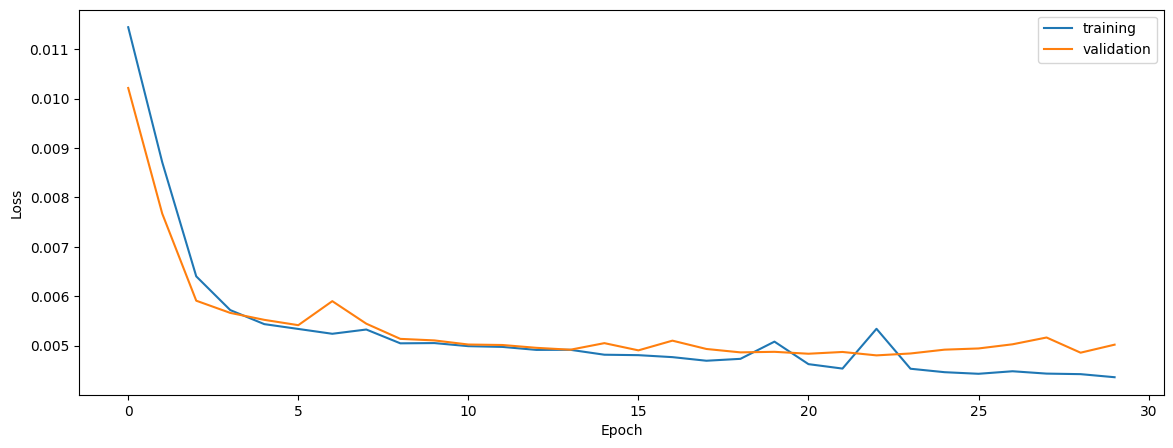

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7210239071842188
0.7306797876488962
0.6952796433596703


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7210239071842188
0.7306797876488962
0.6952796433596703


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7020861266437761
0.7223070746609522
0.666756402556963


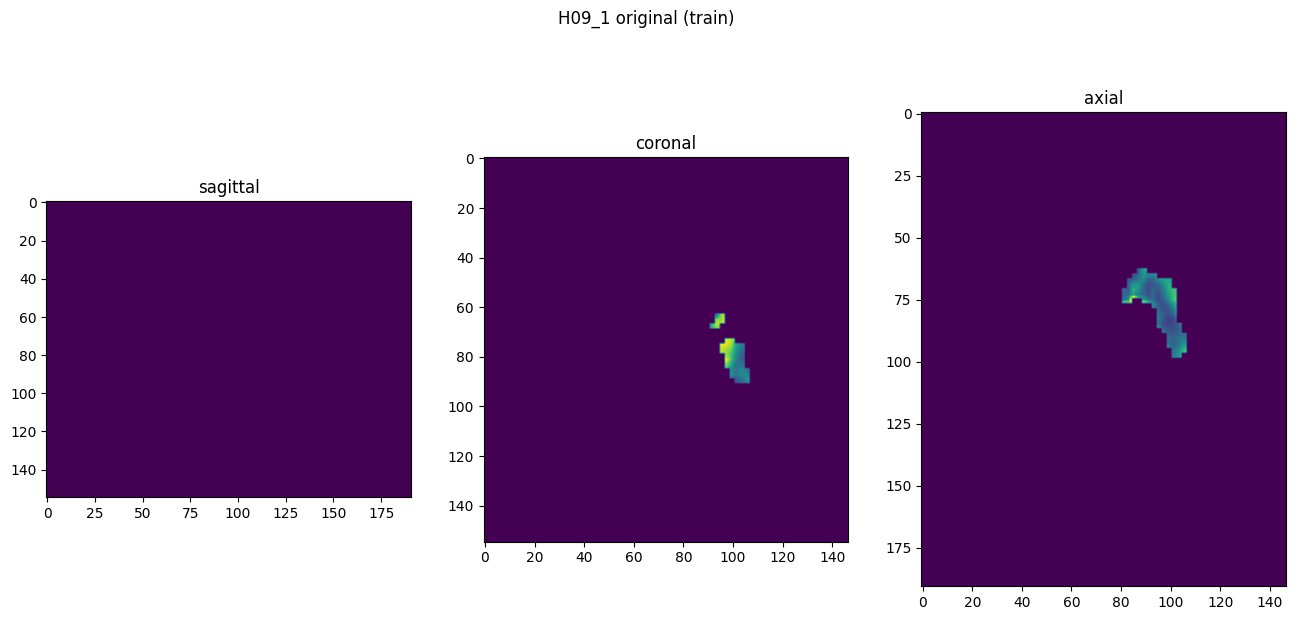

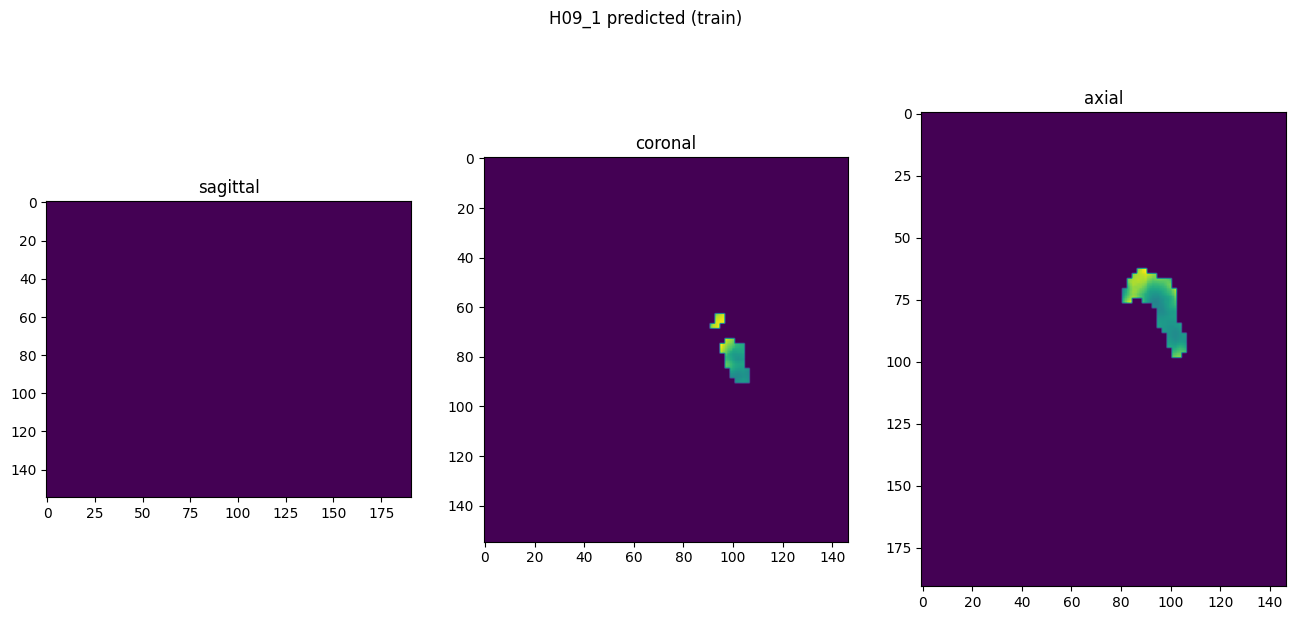

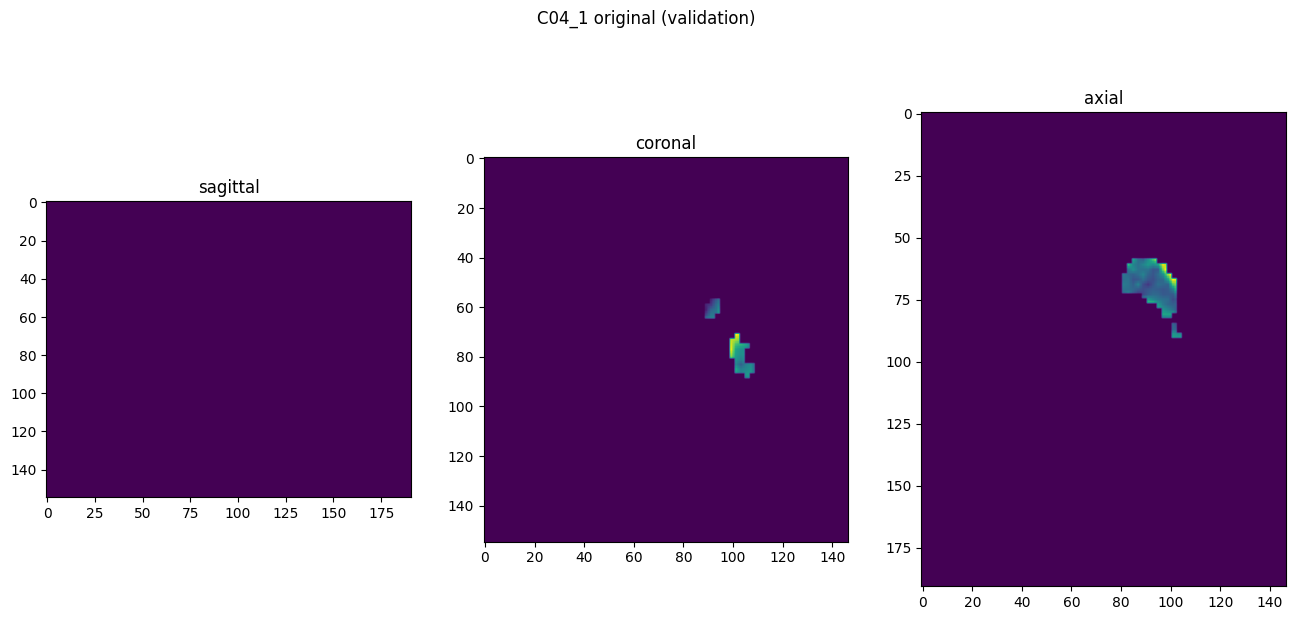

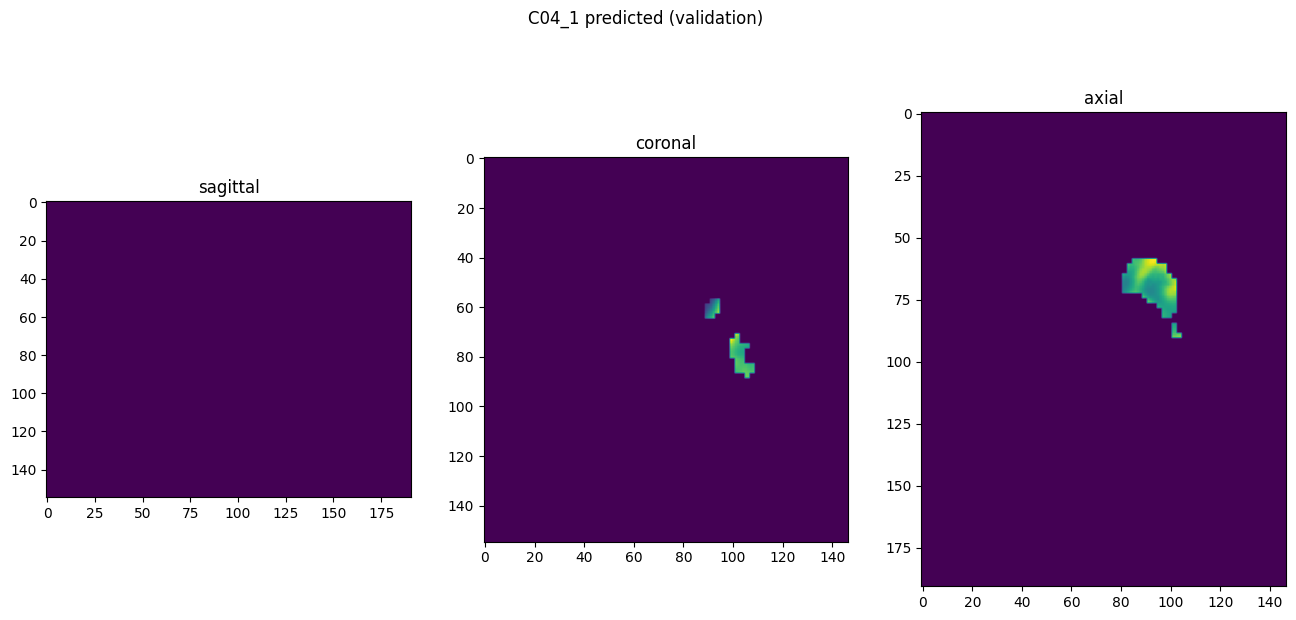

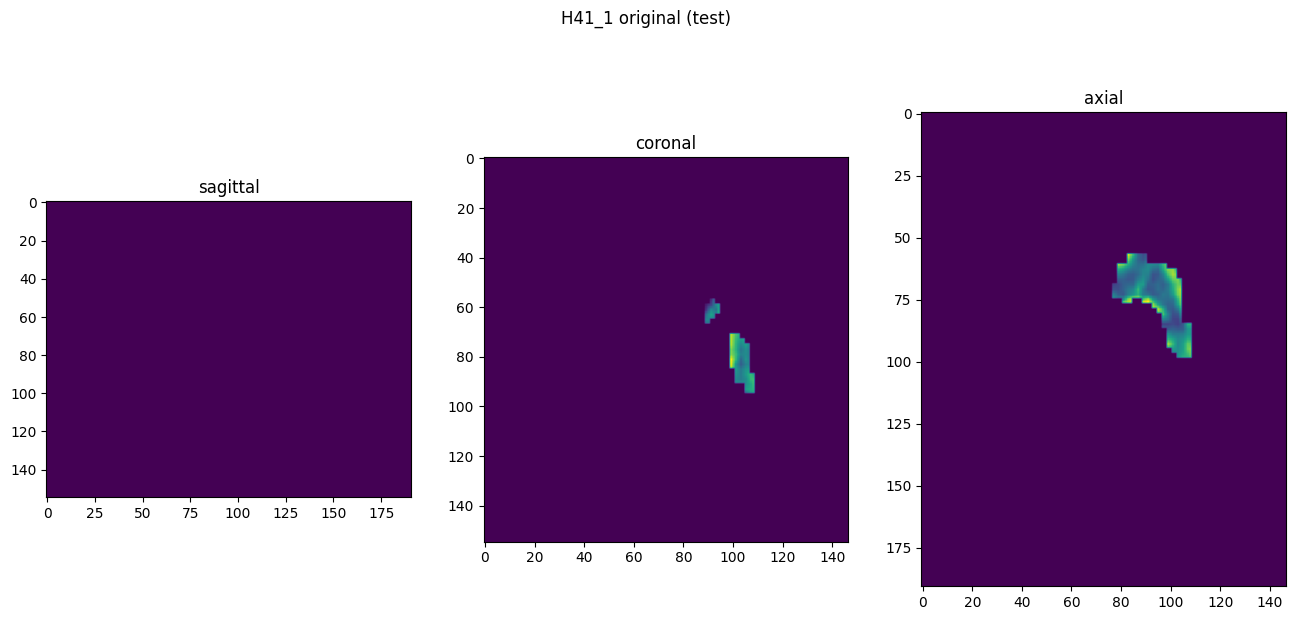

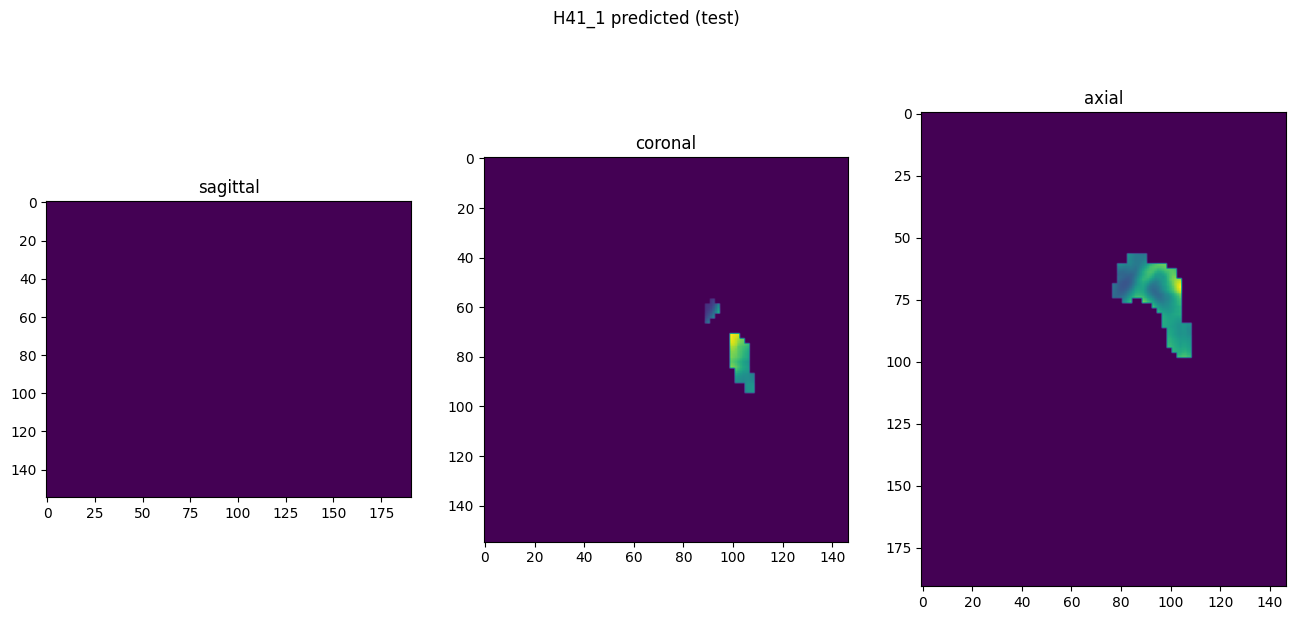

In [10]:
showResults(model, gen, threshold=None, background=False)